<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/full_net_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
Cloning into 'deepLearning'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 381 (delta 68), reused 51 (delta 21), pack-reused 245
Receiving objects: 100% (381/381), 152.26 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (151/151), done.
Checking out files: 100% (108/108), done.
/content/deepLearning
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
RAM Free: 12.9 GB  | Proc size: 142.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
from common import *
!chmod +x setup.sh
!./setup.sh

Using TensorFlow backend.


--2019-03-14 09:21:17--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.26.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:21:17--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-14 09:21:17--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation
from keras.layers import Layer, Lambda

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

def run_sobel(image):
  tmp = tf.image.sobel_edges(image)[:,:,:,0]
  tmp = tf.multiply(tmp[:,:,:,0],tmp[:,:,:,1])
  return tf.expand_dims(tmp,3)
  #return tf.image.sobel_edges(image)[:,:,:,0]
      

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_full_model(shape,denoise_init=None,stn_init=None):  
    #shape = (32, 32, 1)

    init_weights = keras.initializers.he_normal()
    # input 
    inputs = Input(shape)
    
    # denoise network
    depth1  = 16
    conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal', name='denoise_in')(inputs)

    # convolution layers
    conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_2' )(conv1_1)
    conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_3' )(conv1_1)
    conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_5' )(conv1_1)
    conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_7' )(conv1_1)
    conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_9' )(conv1_1)
    conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_1_11')(conv1_1)

    # network
    net1 = Subtract()([conv1_1, conv1_2])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_3])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_5])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_7])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_9])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_11])
    net1 = BatchNormalization()(net1)  

    # convolution layers
    depth2 = 16
    #conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_2' )(net1)
    conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_3' )(net1)
    conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_5' )(net1)
    conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_7' )(net1)
    conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_9' )(net1)
    conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_2_11')(net1)

    # network
    net2 = Subtract()([net1, conv2_2])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_3])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_5])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_7])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_9])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([net1, conv2_11])
    net2 = BatchNormalization()(net2)  

    # convolution layers
    depth3 = 16
    #conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_2' )(net2)
    conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_3' )(net2)
    conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_5' )(net2)
    conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_7' )(net2)
    conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_9' )(net2)
    conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_3_11')(net2)

    # network
    net3 = Subtract()([net2, conv3_2])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_3])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_5])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_7])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_9])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([net2, conv3_11])
    net3 = BatchNormalization()(net3)  

    net3 = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name='denoise_out' )(net3)
    
    # stn network    
    locnet = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_1')(net3) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_2')(locnet) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_3')(locnet)  # 64
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_4')(locnet)  # 128
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Flatten(name='stn_4.1')(locnet)
    locnet = Dense(256, name='stn_5')(locnet)
    locnet =  Dropout(0.25, name='stn_5.1')(locnet)
    locnet = Activation('softmax')(locnet)
    weights = get_initial_weights(256)
    locnet = Dense(6, weights=weights, name='stn_6')(locnet)
    stn    = BilinearInterpolation(shape[:-1])([net3, locnet])
      
    # sobel
    sobel = Lambda(run_sobel)(net3)
    
    # features in
    l2net = concatenate([ net3, stn , sobel ], axis = -1)
    
    # L2 Net    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1, epsilon=0.0001, scale=False, center=False)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 8, padding='valid', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)

    l2net = Reshape((128,))(l2net)
  
    l2net = Model(inputs = inputs, outputs = l2net)
    
    if stn_init:
      l2net.load_weights(stn_init, by_name=True, skip_mismatch=True)
      
    if denoise_init:
      l2net.load_weights(denoise_init, by_name=True, skip_mismatch=True)
    
    descriptor_model = Sequential()
    descriptor_model.add(l2net)
    
    return descriptor_model

    
  
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

#descriptor_model = get_full_model(shape)
descriptor_model = get_full_model(shape,'/content/denoise_model_ssim.weights.06-0.31.hdf5','/content/stn_model.weights.02-25.51.hdf5')

ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [6]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000, batch_size=500)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000, batch_size=500)

Using noisy patches
100%|██████████| 116/116 [00:32<00:00,  2.27it/s]


100%|██████████| 100000/100000 [00:01<00:00, 68118.36it/s]


Using noisy patches
100%|██████████| 116/116 [00:19<00:00,  5.89it/s]


100%|██████████| 10000/10000 [00:00<00:00, 65403.97it/s]


In [7]:
# callbacks
callbacks = [
    #keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=100, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
199/200 [============================>.] - ETA: 0s - loss: 0.4349

100%|██████████| 100000/100000 [00:02<00:00, 36382.03it/s]


200/200 [==============================] - 202s 1s/step - loss: 0.4343 - val_loss: 0.4625

Epoch 00001: val_loss improved from inf to 0.46253, saving model to data/descriptor_model.weights.01-0.46.hdf5


100%|██████████| 10000/10000 [00:00<00:00, 39515.04it/s]


Epoch 2/100
199/200 [============================>.] - ETA: 0s - loss: 0.3113

100%|██████████| 100000/100000 [00:03<00:00, 32502.95it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.3112 - val_loss: 0.4174

Epoch 00002: val_loss improved from 0.46253 to 0.41743, saving model to data/descriptor_model.weights.02-0.42.hdf5
Epoch 3/100
  1/200 [..............................] - ETA: 3:03 - loss: 0.2428

100%|██████████| 10000/10000 [00:00<00:00, 36452.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2819

100%|██████████| 100000/100000 [00:02<00:00, 37488.41it/s]


200/200 [==============================] - 189s 947ms/step - loss: 0.2819 - val_loss: 0.4215

Epoch 00003: val_loss did not improve from 0.41743
Epoch 4/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.2770

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:03 - loss: 0.2832

100%|██████████| 10000/10000 [00:00<00:00, 40634.13it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2602

100%|██████████| 100000/100000 [00:02<00:00, 37320.56it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.2602 - val_loss: 0.3068

Epoch 00004: val_loss improved from 0.41743 to 0.30675, saving model to data/descriptor_model.weights.04-0.31.hdf5
Epoch 5/100
  1/200 [..............................] - ETA: 3:06 - loss: 0.2458

100%|██████████| 10000/10000 [00:00<00:00, 34914.13it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2420

100%|██████████| 100000/100000 [00:02<00:00, 35983.58it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.2419 - val_loss: 0.2845

Epoch 00005: val_loss improved from 0.30675 to 0.28451, saving model to data/descriptor_model.weights.05-0.28.hdf5
Epoch 6/100
  1/200 [..............................] - ETA: 3:06 - loss: 0.2328

100%|██████████| 10000/10000 [00:00<00:00, 36842.69it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2282

100%|██████████| 100000/100000 [00:02<00:00, 34338.40it/s]


200/200 [==============================] - 189s 947ms/step - loss: 0.2281 - val_loss: 0.2664

Epoch 00006: val_loss improved from 0.28451 to 0.26640, saving model to data/descriptor_model.weights.06-0.27.hdf5
Epoch 7/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.2340

100%|██████████| 10000/10000 [00:00<00:00, 38256.81it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2148

100%|██████████| 100000/100000 [00:02<00:00, 38214.56it/s]


200/200 [==============================] - 189s 943ms/step - loss: 0.2147 - val_loss: 0.2922

Epoch 00007: val_loss did not improve from 0.26640
Epoch 8/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.2110

100%|██████████| 10000/10000 [00:00<00:00, 37344.94it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.2069

100%|██████████| 100000/100000 [00:02<00:00, 38595.99it/s]


200/200 [==============================] - 189s 944ms/step - loss: 0.2070 - val_loss: 0.2662

Epoch 00008: val_loss improved from 0.26640 to 0.26616, saving model to data/descriptor_model.weights.08-0.27.hdf5
Epoch 9/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1838

100%|██████████| 10000/10000 [00:00<00:00, 41211.90it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1974

100%|██████████| 100000/100000 [00:02<00:00, 37339.41it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1975 - val_loss: 0.2754

Epoch 00009: val_loss did not improve from 0.26616
Epoch 10/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1749

100%|██████████| 10000/10000 [00:00<00:00, 39271.59it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1898

100%|██████████| 100000/100000 [00:03<00:00, 32979.37it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1898 - val_loss: 0.2183

Epoch 00010: val_loss improved from 0.26616 to 0.21826, saving model to data/descriptor_model.weights.10-0.22.hdf5
Epoch 11/100
  1/200 [..............................] - ETA: 3:05 - loss: 0.1759

100%|██████████| 10000/10000 [00:00<00:00, 38950.73it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1809

100%|██████████| 100000/100000 [00:02<00:00, 36724.17it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1809 - val_loss: 0.2181

Epoch 00011: val_loss improved from 0.21826 to 0.21813, saving model to data/descriptor_model.weights.11-0.22.hdf5


 38%|███▊      | 3788/10000 [00:00<00:00, 37876.06it/s]

Epoch 12/100


100%|██████████| 10000/10000 [00:00<00:00, 34978.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1739

100%|██████████| 100000/100000 [00:02<00:00, 36992.05it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.1739 - val_loss: 0.2898

Epoch 00012: val_loss did not improve from 0.21813
Epoch 13/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.1668

100%|██████████| 10000/10000 [00:00<00:00, 38526.47it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1723

100%|██████████| 100000/100000 [00:02<00:00, 37921.62it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.1726 - val_loss: 0.4014

Epoch 00013: val_loss did not improve from 0.21813
Epoch 14/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1638

100%|██████████| 10000/10000 [00:00<00:00, 35845.50it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1647

100%|██████████| 100000/100000 [00:03<00:00, 31885.89it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1648 - val_loss: 0.2643

Epoch 00014: val_loss did not improve from 0.21813
Epoch 15/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1465

100%|██████████| 10000/10000 [00:00<00:00, 38345.64it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1615

100%|██████████| 100000/100000 [00:02<00:00, 36688.44it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.1616 - val_loss: 0.2732

Epoch 00015: val_loss did not improve from 0.21813
Epoch 16/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1616

100%|██████████| 10000/10000 [00:00<00:00, 37354.52it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1598

100%|██████████| 100000/100000 [00:02<00:00, 37548.45it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1599 - val_loss: 0.3283

Epoch 00016: val_loss did not improve from 0.21813
Epoch 17/100
  1/200 [..............................] - ETA: 3:02 - loss: 0.1341

100%|██████████| 10000/10000 [00:00<00:00, 38883.85it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1577

100%|██████████| 100000/100000 [00:02<00:00, 37517.32it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.1575 - val_loss: 0.1925

Epoch 00017: val_loss improved from 0.21813 to 0.19245, saving model to data/descriptor_model.weights.17-0.19.hdf5
Epoch 18/100
  1/200 [..............................] - ETA: 3:03 - loss: 0.1396

100%|██████████| 10000/10000 [00:00<00:00, 39357.86it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1544

100%|██████████| 100000/100000 [00:03<00:00, 32840.93it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1544 - val_loss: 0.4247

Epoch 00018: val_loss did not improve from 0.19245
Epoch 19/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.1286

100%|██████████| 10000/10000 [00:00<00:00, 35915.92it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1494

100%|██████████| 100000/100000 [00:02<00:00, 36697.50it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1496 - val_loss: 0.3760

Epoch 00019: val_loss did not improve from 0.19245
Epoch 20/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1263

100%|██████████| 10000/10000 [00:00<00:00, 13297.29it/s]

  3/200 [..............................] - ETA: 3:01 - loss: 0.1405

199/200 [============================>.] - ETA: 0s - loss: 0.1465

100%|██████████| 100000/100000 [00:02<00:00, 35256.20it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1466 - val_loss: 0.1890

Epoch 00020: val_loss improved from 0.19245 to 0.18899, saving model to data/descriptor_model.weights.20-0.19.hdf5
Epoch 21/100
  1/200 [..............................] - ETA: 3:05 - loss: 0.1705

100%|██████████| 10000/10000 [00:00<00:00, 40390.47it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1448

100%|██████████| 100000/100000 [00:02<00:00, 34800.87it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1447 - val_loss: 0.3627

Epoch 00021: val_loss did not improve from 0.18899
Epoch 22/100
  1/200 [..............................] - ETA: 4:27 - loss: 0.1280

 86%|████████▌ | 8559/10000 [00:00<00:00, 42278.68it/s]

  2/200 [..............................] - ETA: 3:50 - loss: 0.1219

100%|██████████| 10000/10000 [00:00<00:00, 36252.83it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1421

100%|██████████| 100000/100000 [00:03<00:00, 30339.80it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1421 - val_loss: 0.1915

Epoch 00022: val_loss did not improve from 0.18899
Epoch 23/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1176

100%|██████████| 10000/10000 [00:00<00:00, 36986.02it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1403

100%|██████████| 100000/100000 [00:02<00:00, 34623.33it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1404 - val_loss: 0.3726

Epoch 00023: val_loss did not improve from 0.18899
Epoch 24/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.1293

100%|██████████| 10000/10000 [00:00<00:00, 35115.35it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1395

100%|██████████| 100000/100000 [00:02<00:00, 36515.88it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1395 - val_loss: 0.4892

Epoch 00024: val_loss did not improve from 0.18899
Epoch 25/100
  1/200 [..............................] - ETA: 3:06 - loss: 0.1633

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:06 - loss: 0.1377

100%|██████████| 10000/10000 [00:00<00:00, 33402.07it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1382

100%|██████████| 100000/100000 [00:02<00:00, 36666.77it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1380 - val_loss: 0.2172

Epoch 00025: val_loss did not improve from 0.18899
Epoch 26/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1354

100%|██████████| 10000/10000 [00:00<00:00, 35792.28it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1374

100%|██████████| 100000/100000 [00:03<00:00, 31045.82it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1376 - val_loss: 0.2859

Epoch 00026: val_loss did not improve from 0.18899
Epoch 27/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.1535

100%|██████████| 10000/10000 [00:00<00:00, 38558.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1316

100%|██████████| 100000/100000 [00:02<00:00, 36743.60it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1316 - val_loss: 0.2187

Epoch 00027: val_loss did not improve from 0.18899
Epoch 28/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1283

100%|██████████| 10000/10000 [00:00<00:00, 37038.22it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1328

100%|██████████| 100000/100000 [00:02<00:00, 36824.35it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1329 - val_loss: 0.1927

Epoch 00028: val_loss did not improve from 0.18899
Epoch 29/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1305

100%|██████████| 10000/10000 [00:00<00:00, 38460.59it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1303

100%|██████████| 100000/100000 [00:02<00:00, 35474.71it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1304 - val_loss: 0.2500

Epoch 00029: val_loss did not improve from 0.18899
Epoch 30/100
  1/200 [..............................] - ETA: 3:06 - loss: 0.1217

 79%|███████▉  | 7906/10000 [00:00<00:00, 39398.01it/s]

  2/200 [..............................] - ETA: 3:04 - loss: 0.1237

100%|██████████| 10000/10000 [00:00<00:00, 39134.73it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1301

100%|██████████| 100000/100000 [00:03<00:00, 30128.94it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.1302 - val_loss: 0.1668

Epoch 00030: val_loss improved from 0.18899 to 0.16679, saving model to data/descriptor_model.weights.30-0.17.hdf5
Epoch 31/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1405

100%|██████████| 10000/10000 [00:00<00:00, 36756.74it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1285

100%|██████████| 100000/100000 [00:02<00:00, 35069.09it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1286 - val_loss: 0.1820

Epoch 00031: val_loss did not improve from 0.16679
Epoch 32/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1145

100%|██████████| 10000/10000 [00:00<00:00, 34406.87it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1248

100%|██████████| 100000/100000 [00:02<00:00, 34848.33it/s]


200/200 [==============================] - 192s 959ms/step - loss: 0.1248 - val_loss: 0.1608

Epoch 00032: val_loss improved from 0.16679 to 0.16079, saving model to data/descriptor_model.weights.32-0.16.hdf5
Epoch 33/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1066

100%|██████████| 10000/10000 [00:00<00:00, 38241.49it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1249

100%|██████████| 100000/100000 [00:02<00:00, 35087.12it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1251 - val_loss: 0.3360

Epoch 00033: val_loss did not improve from 0.16079
Epoch 34/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1486

100%|██████████| 10000/10000 [00:00<00:00, 35086.77it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1239

100%|██████████| 100000/100000 [00:03<00:00, 30349.50it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.1238 - val_loss: 0.2024

Epoch 00034: val_loss did not improve from 0.16079
Epoch 35/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1109

100%|██████████| 10000/10000 [00:00<00:00, 33295.16it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1261

100%|██████████| 100000/100000 [00:02<00:00, 36651.34it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1261 - val_loss: 0.4798

Epoch 00035: val_loss did not improve from 0.16079
Epoch 36/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.1187

100%|██████████| 10000/10000 [00:00<00:00, 35979.69it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1233

100%|██████████| 100000/100000 [00:02<00:00, 35775.10it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1234 - val_loss: 0.3333

Epoch 00036: val_loss did not improve from 0.16079
Epoch 37/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1327

100%|██████████| 10000/10000 [00:00<00:00, 35502.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1205

100%|██████████| 100000/100000 [00:03<00:00, 31650.57it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1205 - val_loss: 0.1821

Epoch 00037: val_loss did not improve from 0.16079
Epoch 38/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1075

100%|██████████| 10000/10000 [00:00<00:00, 35291.92it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1209

100%|██████████| 100000/100000 [00:03<00:00, 31584.63it/s]


200/200 [==============================] - 192s 958ms/step - loss: 0.1208 - val_loss: 0.1582

Epoch 00038: val_loss improved from 0.16079 to 0.15816, saving model to data/descriptor_model.weights.38-0.16.hdf5
Epoch 39/100
  1/200 [..............................] - ETA: 3:05 - loss: 0.1211

100%|██████████| 10000/10000 [00:00<00:00, 39840.08it/s]

  2/200 [..............................] - ETA: 3:07 - loss: 0.1232

199/200 [============================>.] - ETA: 0s - loss: 0.1189

100%|██████████| 100000/100000 [00:02<00:00, 37821.63it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1189 - val_loss: 0.2586

Epoch 00039: val_loss did not improve from 0.15816
Epoch 40/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1146

100%|██████████| 10000/10000 [00:00<00:00, 37845.47it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1181

100%|██████████| 100000/100000 [00:02<00:00, 37633.58it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.1181 - val_loss: 0.1750

Epoch 00040: val_loss did not improve from 0.15816
Epoch 41/100
  1/200 [..............................] - ETA: 3:03 - loss: 0.1026

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:05 - loss: 0.1140

100%|██████████| 10000/10000 [00:00<00:00, 38715.20it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1172

100%|██████████| 100000/100000 [00:03<00:00, 33008.36it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.1171 - val_loss: 0.2937

Epoch 00041: val_loss did not improve from 0.15816
Epoch 42/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.1187

 36%|███▌      | 3556/10000 [00:00<00:00, 35557.32it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.1205

100%|██████████| 10000/10000 [00:00<00:00, 35557.54it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1189

100%|██████████| 100000/100000 [00:02<00:00, 37970.41it/s]


200/200 [==============================] - 192s 960ms/step - loss: 0.1188 - val_loss: 0.1905

Epoch 00042: val_loss did not improve from 0.15816
Epoch 43/100
  1/200 [..............................] - ETA: 4:09 - loss: 0.1134

100%|██████████| 10000/10000 [00:00<00:00, 38069.61it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1162

100%|██████████| 100000/100000 [00:02<00:00, 37802.28it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.1162 - val_loss: 0.1573

Epoch 00043: val_loss improved from 0.15816 to 0.15731, saving model to data/descriptor_model.weights.43-0.16.hdf5
Epoch 44/100
  1/200 [..............................] - ETA: 3:09 - loss: 0.1287

100%|██████████| 10000/10000 [00:00<00:00, 37970.59it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1149

100%|██████████| 100000/100000 [00:02<00:00, 40062.19it/s]


200/200 [==============================] - 190s 949ms/step - loss: 0.1149 - val_loss: 0.1571

Epoch 00044: val_loss improved from 0.15731 to 0.15714, saving model to data/descriptor_model.weights.44-0.16.hdf5
Epoch 45/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1210

100%|██████████| 10000/10000 [00:00<00:00, 40284.72it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1129

100%|██████████| 100000/100000 [00:02<00:00, 33497.89it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1129 - val_loss: 0.2905

Epoch 00045: val_loss did not improve from 0.15714
Epoch 46/100
  1/200 [..............................] - ETA: 3:05 - loss: 0.0973

 40%|███▉      | 3957/10000 [00:00<00:00, 39564.76it/s]

  2/200 [..............................] - ETA: 3:12 - loss: 0.0998

100%|██████████| 10000/10000 [00:00<00:00, 42559.77it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1157

100%|██████████| 100000/100000 [00:02<00:00, 38365.28it/s]


200/200 [==============================] - 190s 949ms/step - loss: 0.1157 - val_loss: 0.2133

Epoch 00046: val_loss did not improve from 0.15714
Epoch 47/100
  2/200 [..............................] - ETA: 3:14 - loss: 0.1381

100%|██████████| 10000/10000 [00:00<00:00, 36918.25it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1162

100%|██████████| 100000/100000 [00:02<00:00, 38566.83it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1163 - val_loss: 0.1763

Epoch 00047: val_loss did not improve from 0.15714
Epoch 48/100
  1/200 [..............................] - ETA: 3:03 - loss: 0.0896

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:06 - loss: 0.1070

100%|██████████| 10000/10000 [00:00<00:00, 34357.18it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1132

100%|██████████| 100000/100000 [00:02<00:00, 38397.09it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1132 - val_loss: 0.4209

Epoch 00048: val_loss did not improve from 0.15714
Epoch 49/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1120

100%|██████████| 10000/10000 [00:00<00:00, 33380.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1120

100%|██████████| 100000/100000 [00:02<00:00, 37355.09it/s]


200/200 [==============================] - 192s 961ms/step - loss: 0.1121 - val_loss: 0.3490

Epoch 00049: val_loss did not improve from 0.15714
Epoch 50/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1329

100%|██████████| 10000/10000 [00:00<00:00, 35659.82it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1102

100%|██████████| 100000/100000 [00:03<00:00, 31144.27it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.1101 - val_loss: 0.1750

Epoch 00050: val_loss did not improve from 0.15714
Epoch 51/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1087

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:06 - loss: 0.1218

100%|██████████| 10000/10000 [00:00<00:00, 35137.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1118

100%|██████████| 100000/100000 [00:02<00:00, 37086.59it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.1119 - val_loss: 0.1909

Epoch 00051: val_loss did not improve from 0.15714
Epoch 52/100
  1/200 [..............................] - ETA: 3:08 - loss: 0.1077

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:08 - loss: 0.1142

100%|██████████| 10000/10000 [00:00<00:00, 31638.72it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1093

100%|██████████| 100000/100000 [00:02<00:00, 37271.23it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1094 - val_loss: 0.1466

Epoch 00052: val_loss improved from 0.15714 to 0.14660, saving model to data/descriptor_model.weights.52-0.15.hdf5
Epoch 53/100
  1/200 [..............................] - ETA: 3:06 - loss: 0.1234

100%|██████████| 10000/10000 [00:00<00:00, 39462.69it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1102

100%|██████████| 100000/100000 [00:02<00:00, 39307.41it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.1102 - val_loss: 0.1450

Epoch 00053: val_loss improved from 0.14660 to 0.14501, saving model to data/descriptor_model.weights.53-0.15.hdf5
Epoch 54/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.0951

100%|██████████| 10000/10000 [00:00<00:00, 40755.59it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1091

100%|██████████| 100000/100000 [00:03<00:00, 33276.16it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.1092 - val_loss: 0.1698

Epoch 00054: val_loss did not improve from 0.14501
Epoch 55/100
  1/200 [..............................] - ETA: 3:15 - loss: 0.0875

100%|██████████| 10000/10000 [00:00<00:00, 40137.65it/s]

  2/200 [..............................] - ETA: 3:13 - loss: 0.0808

199/200 [============================>.] - ETA: 0s - loss: 0.1070

100%|██████████| 100000/100000 [00:02<00:00, 37659.39it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.1071 - val_loss: 0.2413

Epoch 00055: val_loss did not improve from 0.14501
Epoch 56/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.1037

100%|██████████| 10000/10000 [00:00<00:00, 36117.72it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1085

100%|██████████| 100000/100000 [00:02<00:00, 36744.54it/s]


200/200 [==============================] - 189s 945ms/step - loss: 0.1085 - val_loss: 0.1461

Epoch 00056: val_loss did not improve from 0.14501
Epoch 57/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1060

100%|██████████| 10000/10000 [00:00<00:00, 36375.36it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1100

100%|██████████| 100000/100000 [00:02<00:00, 36967.68it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.1098 - val_loss: 0.1484

Epoch 00057: val_loss did not improve from 0.14501
Epoch 58/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1156

100%|██████████| 10000/10000 [00:00<00:00, 35361.22it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1066

100%|██████████| 100000/100000 [00:03<00:00, 31521.17it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1066 - val_loss: 0.2617

Epoch 00058: val_loss did not improve from 0.14501
Epoch 59/100
  2/200 [..............................] - ETA: 3:09 - loss: 0.1024

100%|██████████| 10000/10000 [00:00<00:00, 34080.28it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1061

100%|██████████| 100000/100000 [00:02<00:00, 36064.45it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.1061 - val_loss: 0.2902

Epoch 00059: val_loss did not improve from 0.14501
Epoch 60/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1077

100%|██████████| 10000/10000 [00:00<00:00, 36332.69it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1053

100%|██████████| 100000/100000 [00:02<00:00, 36112.91it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1052 - val_loss: 0.1725

Epoch 00060: val_loss did not improve from 0.14501
Epoch 61/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1233

100%|██████████| 10000/10000 [00:00<00:00, 34491.64it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1068

100%|██████████| 100000/100000 [00:02<00:00, 36524.71it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1069 - val_loss: 0.2195

Epoch 00061: val_loss did not improve from 0.14501
Epoch 62/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.0922

100%|██████████| 10000/10000 [00:00<00:00, 33838.35it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1042

100%|██████████| 100000/100000 [00:03<00:00, 30912.13it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1042 - val_loss: 0.1960

Epoch 00062: val_loss did not improve from 0.14501
Epoch 63/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1094

100%|██████████| 10000/10000 [00:00<00:00, 38077.66it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1031

100%|██████████| 100000/100000 [00:02<00:00, 36855.72it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1030 - val_loss: 0.1451

Epoch 00063: val_loss did not improve from 0.14501
Epoch 64/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.0896

100%|██████████| 10000/10000 [00:00<00:00, 34189.12it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1024

100%|██████████| 100000/100000 [00:02<00:00, 37033.15it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1026 - val_loss: 0.2802

Epoch 00064: val_loss did not improve from 0.14501
Epoch 65/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1112

100%|██████████| 10000/10000 [00:00<00:00, 38125.36it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1014

100%|██████████| 100000/100000 [00:03<00:00, 32052.97it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1014 - val_loss: 0.1750

Epoch 00065: val_loss did not improve from 0.14501
Epoch 66/100
  2/200 [..............................] - ETA: 3:09 - loss: 0.0983

100%|██████████| 10000/10000 [00:00<00:00, 36543.61it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1007

100%|██████████| 100000/100000 [00:03<00:00, 32331.21it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.1006 - val_loss: 0.2119

Epoch 00066: val_loss did not improve from 0.14501
Epoch 67/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.1222

100%|██████████| 10000/10000 [00:00<00:00, 36361.98it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1058

100%|██████████| 100000/100000 [00:02<00:00, 37234.87it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.1057 - val_loss: 0.3011

Epoch 00067: val_loss did not improve from 0.14501
Epoch 68/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.0958

100%|██████████| 10000/10000 [00:00<00:00, 35025.04it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1020

100%|██████████| 100000/100000 [00:02<00:00, 36513.36it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1020 - val_loss: 0.1507

Epoch 00068: val_loss did not improve from 0.14501
Epoch 69/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1171

100%|██████████| 10000/10000 [00:00<00:00, 34105.27it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1009

100%|██████████| 100000/100000 [00:03<00:00, 30828.46it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.1008 - val_loss: 0.1545

Epoch 00069: val_loss did not improve from 0.14501
Epoch 70/100
  1/200 [..............................] - ETA: 4:18 - loss: 0.1226

100%|██████████| 10000/10000 [00:00<00:00, 39250.94it/s]

  2/200 [..............................] - ETA: 3:41 - loss: 0.1233

199/200 [============================>.] - ETA: 0s - loss: 0.1011

100%|██████████| 100000/100000 [00:02<00:00, 36218.24it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1012 - val_loss: 0.1321

Epoch 00070: val_loss improved from 0.14501 to 0.13211, saving model to data/descriptor_model.weights.70-0.13.hdf5
Epoch 71/100
  1/200 [..............................] - ETA: 3:56 - loss: 0.1152

100%|██████████| 10000/10000 [00:00<00:00, 38037.43it/s]

  2/200 [..............................] - ETA: 3:35 - loss: 0.1097

199/200 [============================>.] - ETA: 0s - loss: 0.1038

100%|██████████| 100000/100000 [00:02<00:00, 36508.29it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1037 - val_loss: 0.1418

Epoch 00071: val_loss did not improve from 0.13211
Epoch 72/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.1109

100%|██████████| 10000/10000 [00:00<00:00, 38325.67it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1012

100%|██████████| 100000/100000 [00:02<00:00, 34607.77it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.1012 - val_loss: 0.1331

Epoch 00072: val_loss did not improve from 0.13211
Epoch 73/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.1120

100%|██████████| 10000/10000 [00:00<00:00, 33320.26it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0999

100%|██████████| 100000/100000 [00:02<00:00, 35184.56it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.0998 - val_loss: 0.1759

Epoch 00073: val_loss did not improve from 0.13211
Epoch 74/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1464

100%|██████████| 10000/10000 [00:00<00:00, 39217.58it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0994

100%|██████████| 100000/100000 [00:03<00:00, 31784.94it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.0993 - val_loss: 0.1281

Epoch 00074: val_loss improved from 0.13211 to 0.12813, saving model to data/descriptor_model.weights.74-0.13.hdf5
Epoch 75/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.1138

100%|██████████| 10000/10000 [00:00<00:00, 40480.83it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1012

100%|██████████| 100000/100000 [00:02<00:00, 36637.14it/s]


200/200 [==============================] - 190s 948ms/step - loss: 0.1012 - val_loss: 0.1598

Epoch 00075: val_loss did not improve from 0.12813
Epoch 76/100
  2/200 [..............................] - ETA: 3:03 - loss: 0.1040

100%|██████████| 10000/10000 [00:00<00:00, 35344.47it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.1001

100%|██████████| 100000/100000 [00:02<00:00, 34947.80it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.1000 - val_loss: 0.1384

Epoch 00076: val_loss did not improve from 0.12813
Epoch 77/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.0993

100%|██████████| 10000/10000 [00:00<00:00, 32042.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0967

100%|██████████| 100000/100000 [00:02<00:00, 36253.42it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.0967 - val_loss: 0.1709

Epoch 00077: val_loss did not improve from 0.12813
Epoch 78/100
  2/200 [..............................] - ETA: 3:09 - loss: 0.0960

100%|██████████| 10000/10000 [00:00<00:00, 33818.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0966

100%|██████████| 100000/100000 [00:03<00:00, 31804.68it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.0966 - val_loss: 0.1354

Epoch 00078: val_loss did not improve from 0.12813
Epoch 79/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1055

100%|██████████| 10000/10000 [00:00<00:00, 33375.17it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0980

100%|██████████| 100000/100000 [00:02<00:00, 35687.62it/s]


200/200 [==============================] - 189s 946ms/step - loss: 0.0980 - val_loss: 0.2396

Epoch 00079: val_loss did not improve from 0.12813
Epoch 80/100
  2/200 [..............................] - ETA: 3:03 - loss: 0.0998

100%|██████████| 10000/10000 [00:00<00:00, 34213.91it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0972

100%|██████████| 100000/100000 [00:02<00:00, 36532.40it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.0973 - val_loss: 0.1375

Epoch 00080: val_loss did not improve from 0.12813
Epoch 81/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.0916

100%|██████████| 10000/10000 [00:00<00:00, 36901.71it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0971

100%|██████████| 100000/100000 [00:02<00:00, 35816.91it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.0971 - val_loss: 0.1555

Epoch 00081: val_loss did not improve from 0.12813
Epoch 82/100
  2/200 [..............................] - ETA: 3:08 - loss: 0.0942

100%|██████████| 10000/10000 [00:00<00:00, 37619.64it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0966

100%|██████████| 100000/100000 [00:03<00:00, 31509.99it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.0966 - val_loss: 0.1620

Epoch 00082: val_loss did not improve from 0.12813
Epoch 83/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1098

100%|██████████| 10000/10000 [00:00<00:00, 39288.14it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0980

100%|██████████| 100000/100000 [00:02<00:00, 36266.73it/s]


200/200 [==============================] - 189s 947ms/step - loss: 0.0981 - val_loss: 0.1396

Epoch 00083: val_loss did not improve from 0.12813
Epoch 84/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.0978

100%|██████████| 10000/10000 [00:00<00:00, 13431.40it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0953

100%|██████████| 100000/100000 [00:02<00:00, 37266.54it/s]


200/200 [==============================] - 190s 952ms/step - loss: 0.0954 - val_loss: 0.3349

Epoch 00084: val_loss did not improve from 0.12813
Epoch 85/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.1031

100%|██████████| 10000/10000 [00:00<00:00, 37455.93it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0964

100%|██████████| 100000/100000 [00:02<00:00, 37187.90it/s]


200/200 [==============================] - 190s 949ms/step - loss: 0.0963 - val_loss: 0.1409

Epoch 00085: val_loss did not improve from 0.12813
Epoch 86/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.0961

100%|██████████| 10000/10000 [00:00<00:00, 37746.80it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0959

100%|██████████| 100000/100000 [00:03<00:00, 31586.46it/s]


200/200 [==============================] - 190s 951ms/step - loss: 0.0959 - val_loss: 0.1459

Epoch 00086: val_loss did not improve from 0.12813
Epoch 87/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.0900

100%|██████████| 10000/10000 [00:00<00:00, 38365.46it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0953

100%|██████████| 100000/100000 [00:02<00:00, 37215.35it/s]


200/200 [==============================] - 190s 949ms/step - loss: 0.0952 - val_loss: 0.2100

Epoch 00087: val_loss did not improve from 0.12813
Epoch 88/100
  2/200 [..............................] - ETA: 3:06 - loss: 0.0823

100%|██████████| 10000/10000 [00:00<00:00, 13181.54it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0952

100%|██████████| 100000/100000 [00:02<00:00, 38694.12it/s]


200/200 [==============================] - 189s 947ms/step - loss: 0.0955 - val_loss: 0.1738

Epoch 00088: val_loss did not improve from 0.12813
Epoch 89/100
  1/200 [..............................] - ETA: 3:04 - loss: 0.1003

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:04 - loss: 0.1035

100%|██████████| 10000/10000 [00:00<00:00, 34343.06it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0961

100%|██████████| 100000/100000 [00:02<00:00, 38230.88it/s]


200/200 [==============================] - 191s 953ms/step - loss: 0.0961 - val_loss: 0.1375

Epoch 00089: val_loss did not improve from 0.12813
Epoch 90/100
  1/200 [..............................] - ETA: 3:03 - loss: 0.0959

  0%|          | 0/10000 [00:00<?, ?it/s]

  2/200 [..............................] - ETA: 3:08 - loss: 0.1074

100%|██████████| 10000/10000 [00:00<00:00, 37642.57it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0956

100%|██████████| 100000/100000 [00:03<00:00, 32427.68it/s]


200/200 [==============================] - 191s 954ms/step - loss: 0.0956 - val_loss: 0.1553

Epoch 00090: val_loss did not improve from 0.12813
Epoch 91/100
  2/200 [..............................] - ETA: 3:03 - loss: 0.0906

100%|██████████| 10000/10000 [00:00<00:00, 39124.51it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0942

100%|██████████| 100000/100000 [00:02<00:00, 36411.75it/s]


200/200 [==============================] - 191s 956ms/step - loss: 0.0943 - val_loss: 0.1689

Epoch 00091: val_loss did not improve from 0.12813
Epoch 92/100
  2/200 [..............................] - ETA: 3:04 - loss: 0.0991

100%|██████████| 10000/10000 [00:00<00:00, 31095.57it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0946

100%|██████████| 100000/100000 [00:02<00:00, 37514.77it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.0947 - val_loss: 0.2161

Epoch 00092: val_loss did not improve from 0.12813
Epoch 93/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.0723

100%|██████████| 10000/10000 [00:00<00:00, 39300.00it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0939

100%|██████████| 100000/100000 [00:02<00:00, 36426.34it/s]


200/200 [==============================] - 190s 949ms/step - loss: 0.0938 - val_loss: 0.1236

Epoch 00093: val_loss improved from 0.12813 to 0.12355, saving model to data/descriptor_model.weights.93-0.12.hdf5
Epoch 94/100
  1/200 [..............................] - ETA: 3:07 - loss: 0.1075

100%|██████████| 10000/10000 [00:00<00:00, 37869.05it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0940

100%|██████████| 100000/100000 [00:03<00:00, 32669.09it/s]


200/200 [==============================] - 192s 958ms/step - loss: 0.0940 - val_loss: 0.2018

Epoch 00094: val_loss did not improve from 0.12355
Epoch 95/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.1024

100%|██████████| 10000/10000 [00:00<00:00, 36849.97it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0929

100%|██████████| 100000/100000 [00:02<00:00, 37777.15it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.0930 - val_loss: 0.1278

Epoch 00095: val_loss did not improve from 0.12355
Epoch 96/100
  2/200 [..............................] - ETA: 3:05 - loss: 0.0855

100%|██████████| 10000/10000 [00:00<00:00, 39042.86it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0930

100%|██████████| 100000/100000 [00:02<00:00, 37496.20it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.0929 - val_loss: 0.1308

Epoch 00096: val_loss did not improve from 0.12355
Epoch 97/100
  2/200 [..............................] - ETA: 3:02 - loss: 0.0959

100%|██████████| 10000/10000 [00:00<00:00, 35397.42it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0934

100%|██████████| 100000/100000 [00:02<00:00, 33540.18it/s]


200/200 [==============================] - 191s 957ms/step - loss: 0.0933 - val_loss: 0.1214

Epoch 00097: val_loss improved from 0.12355 to 0.12141, saving model to data/descriptor_model.weights.97-0.12.hdf5
Epoch 98/100
  1/200 [..............................] - ETA: 3:05 - loss: 0.1130

100%|██████████| 10000/10000 [00:00<00:00, 34979.96it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0937

100%|██████████| 100000/100000 [00:03<00:00, 32404.86it/s]


200/200 [==============================] - 191s 955ms/step - loss: 0.0938 - val_loss: 0.2686

Epoch 00098: val_loss did not improve from 0.12141
Epoch 99/100
  2/200 [..............................] - ETA: 3:09 - loss: 0.1296

100%|██████████| 10000/10000 [00:00<00:00, 36527.60it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0916

100%|██████████| 100000/100000 [00:02<00:00, 36420.20it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.0914 - val_loss: 0.1843

Epoch 00099: val_loss did not improve from 0.12141
Epoch 100/100
  2/200 [..............................] - ETA: 3:07 - loss: 0.0888

100%|██████████| 10000/10000 [00:00<00:00, 34092.08it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0909

100%|██████████| 100000/100000 [00:02<00:00, 37479.68it/s]


200/200 [==============================] - 190s 950ms/step - loss: 0.0909 - val_loss: 0.1571

Epoch 00100: val_loss did not improve from 0.12141


100%|██████████| 10000/10000 [00:00<00:00, 67088.04it/s]


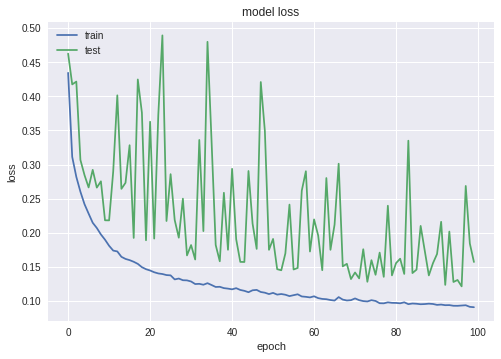

In [11]:

plt.plot(descriptor_history.history['loss'])
plt.plot(descriptor_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

np.save('data/net_loss.npy'    ,np.array(descriptor_history.history['loss']))
np.save('data/net_val_loss.npy',np.array(descriptor_history.history['val_loss']))


In [9]:
from keras.models import load_model
from get_data import get_data
%cd hpatches-benchmark
!git pull 
%cd ..
!mkdir -p results

generate_desc_csv(descriptor_model, seqs_test, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

/content/deepLearning/hpatches-benchmark
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/AlexMontgomerie/deepLearning
   1b30f51..37ffdf3  master     -> origin/master
Updating 1b30f51..37ffdf3
Fast-forward
 full_net_best.ipynb | 2223 +++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 2223 insertions(+)
 create mode 100644 full_net_best.ipynb
/content/deepLearning


100%|██████████| 40/40 [07:16<00:00,  7.44s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:27<00:00, 11380.50it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:27<00:00, 11473.83it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:28<00:00, 11290.57it/s]
>> Verification task finished in 271 secs  
Verification task results:
Mean Average Precision is 0.772535

>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:02<00:00,  4.16s/it]
>> Matching task finished in 123 secs  
Matching task results:
Mean Average Precision is 0.170107



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc